We visualize the trajectory of the simulation for fixed inputs with different initial conditions.

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import math
from perturbed_organics.spectrum_general import matrix_solution
from perturbed_organics.spectrum_general import sim_solution
import perturbed_organics.model.ORGaNICs_models as organics
import perturbed_organics.utils as utils
import scipy.signal as signal
import numpy as np
from joblib import Parallel, delayed, parallel_backend
import argparse
import os
from matplotlib import colors
from scipy.optimize import fsolve, curve_fit
from scipy import integrate
import warnings
import shutil
import json

In [26]:
N = 100
params = {"N_y": N, "N_a": N, "eta": 0.02, "noise_type": "additive"}

b0 = 1.0 * torch.ones(N)
b1 = 1.0 * torch.ones(N)

sigma = torch.tensor([0.1])
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
# Wyy = torch.eye(N)
Way = torch.ones(N, N)

In [38]:
mu = 0.0
delta = 0.8

Wyy = torch.eye(N) + utils.generate_matrix(N=N, matrix_type='goe_symmetric', s=N, mu=mu, delta=delta)

In [39]:
# define the time vector
tau_min = min(torch.min(tauA), torch.min(tauY))
tau_max= max(torch.max(tauA), torch.max(tauY))
chunk_time = 100 * tau_max  # Simulate in chunks of 50 * tau_max
dt = 0.05 * tau_min
points = int(chunk_time / dt)  # Number of points per chunk
t_chunk = torch.linspace(0, chunk_time, points)

In [40]:
def is_diverging(trajectory, max_val=1e10):
    """
    Check if the trajectory is diverging (NaNs or excessively large values).
    Args:
        trajectory (torch.Tensor): Shape (time_steps, state_dim)
        max_val (float): Threshold for detecting divergence
    Returns:
        bool: True if the trajectory is diverging
    """
    return torch.any(torch.isnan(trajectory)) or torch.any(torch.abs(trajectory) > max_val)

def is_fixed_point(trajectory, last_percent=0.5, tol=1e-5):
    """
    Check if the trajectory has converged to a fixed point using the last percentage of the signal.
    
    Args:
        trajectory (torch.Tensor): Shape (time_steps, state_dim)
        last_percent (float): Fraction of the trajectory to use (0 < last_percent <= 1)
        tol (float): Tolerance for detecting fixed points
        
    Returns:
        bool: True if the trajectory is at a fixed point, False otherwise.
    """
    n_points = len(trajectory)
    if n_points == 0 or not (0 < last_percent <= 1):
        raise ValueError("last_percent must be between 0 and 1 (exclusive 0, inclusive 1) and trajectory cannot be empty.")
    
    window = int(n_points * last_percent)
    # Ensure we have at least two points to compare
    if window < 2:
        return False
    
    last_window = trajectory[-window:]  # Shape (window, state_dim)
    diffs = torch.abs(last_window[1:] - last_window[:-1])  # Shape (window-1, state_dim)
    max_diff = torch.max(diffs)
    
    return max_diff < tol

def is_oscillatory(signal_data, min_cycles=2, tol_period=0.01, tol_amplitude=1e-4, last_percent=0.5):
    """
    Determine if a 1D time series exhibits stable oscillatory behavior in its final segment.
    
    This function detects peaks and troughs in the final portion of the signal and assumes 
    that each cycle is defined by a peak followed by the next trough. It computes the amplitude
    of each cycle as the difference between the peak value and the following trough value, then
    checks the consistency of the cycle intervals and amplitudes.
    
    Parameters:
        signal_data (np.array): 1D array of signal values.
        min_cycles (int): Minimum number of cycles (peak followed by trough pairs) required.
        tol_period (float): Maximum allowed relative standard deviation of intervals between cycles.
        tol_amplitude (float): Maximum allowed relative standard deviation of cycle amplitudes.
        last_percent (float): Fraction (0, 1] of the final signal to consider for analysis.
        
    Returns:
        bool: True if the final segment exhibits stable oscillatory behavior, False otherwise.
    """
    if not (0 < last_percent <= 1):
        raise ValueError("last_percent must be in the interval (0, 1].")
    
    total_points = len(signal_data)
    cutoff = int(total_points * (1 - last_percent))
    recent_signal = signal_data[cutoff:]
    
    # Detect peaks and troughs in the recent segment.
    peaks, _ = signal.find_peaks(recent_signal)
    troughs, _ = signal.find_peaks(-recent_signal)
    
    if len(peaks) < min_cycles or len(troughs) == 0:
        return False

    cycle_amplitudes = []
    cycle_peaks = []
    
    # For each peak, find the first trough that comes after it using np.searchsorted.
    for peak in peaks:
        idx = np.searchsorted(troughs, peak, side='right')
        if idx < len(troughs):
            amplitude = recent_signal[peak] - recent_signal[troughs[idx]]
            cycle_amplitudes.append(amplitude)
            cycle_peaks.append(peak)
    
    if len(cycle_amplitudes) < min_cycles:
        return False

    # Calculate cycle intervals based on the peak positions.
    intervals = np.diff(cycle_peaks)
    if intervals.size == 0:
        return False

    mean_interval = np.mean(intervals)
    if mean_interval == 0:
        return False
    rel_std_interval = np.std(intervals) / mean_interval
    if rel_std_interval >= tol_period:
        return False

    # Check amplitude consistency.

    cycle_amplitudes = np.array(cycle_amplitudes)
    # return false if cycle amplitudes has less than 2 entrie
    if len(cycle_amplitudes) < 2:
        return False
    
    # check diff between all amplitudes and they should be lelow tol_amplitude
    if np.any(np.abs(np.diff(cycle_amplitudes) / cycle_amplitudes[-1]) > tol_amplitude):
        return False

    return True

def is_periodic_fft(signal_data, tol=1e-2, min_peak_height=0.8, min_cycles=2):
    """
    Determines if the 1D NumPy array 'signal_data' is periodic using an FFT-based approach.
    It computes the autocorrelation via FFT and checks if there is a strong, repeating peak
    pattern indicating a constant period and amplitude across cycles.
    
    Parameters:
      signal_data : numpy.ndarray
          1D array of numerical values.
      tol : float
          Tolerance for deviations in the autocorrelation (default 1e-2).
      min_peak_height : float
          Minimum relative height (compared to 1 at lag 0) required for peaks in the autocorrelation.
      min_cycles : int
          Minimum number of cycles (repetitions of the candidate period) required.
          
    Returns:
      bool
          True if the signal is periodic (with identical cycles), False otherwise.
    """
    n = len(signal_data)
    if n < 2:
        return True

    # Remove mean to eliminate the DC component
    signal_data = signal_data - np.mean(signal_data)
    
    # Next power of 2 for zero-padding (for better FFT performance and resolution)
    nfft = 2**int(np.ceil(np.log2(2*n - 1)))
    
    # Compute FFT and then the autocorrelation using the Wiener–Khinchin theorem
    fft_signal = np.fft.fft(signal_data, n=nfft)
    ac_full = np.fft.ifft(np.abs(fft_signal)**2).real
    ac = ac_full[:n]  # take only nonnegative lags
    
    # Normalize the autocorrelation so that ac[0] = 1.
    if ac[0] == 0:
        return False
    ac /= ac[0]

    # Find peaks in the autocorrelation (ignoring the zero lag)
    peaks, properties = signal.find_peaks(ac[1:], height=min_peak_height)
    # Adjust indices since we skipped index 0.
    peaks = peaks + 1
    
    if len(peaks) == 0:
        return False

    # Choose the first peak as the candidate period.
    candidate_period = peaks[0]

    # Check that there are at least 'min_cycles' complete periods.
    if n // candidate_period < min_cycles:
        return False

    # Now verify that the autocorrelation at multiples of the candidate period remains high.
    # We allow for a small deviation given by tol.
    num_checks = n // candidate_period
    for k in range(1, num_checks):
        lag = k * candidate_period
        # If the autocorrelation at this lag drops below (min_peak_height - tol), we fail.
        if lag < len(ac) and ac[lag] < (min_peak_height - tol):
            return False

    return True

def is_periodic(signal_data, tol_period=1e-2, tolerance=1e-2):
    # Find maxima and minima
    maxima, _ = signal.find_peaks(signal_data)
    minima, _ = signal.find_peaks(-signal_data)
    
    # Combine and sort all extrema
    extrema = np.sort(np.concatenate((maxima, minima)))
    
    if len(extrema) < 4:  # Need at least two full cycles
        return False
    
    # Calculate periods
    periods = np.diff(extrema[::2])  # Every other extremum for full cycles

    mean_interval = np.mean(periods)
    if mean_interval == 0:
        return False
    rel_std_interval = np.std(periods) / mean_interval
    if rel_std_interval >= tol_period:
        return False
    
    # Check amplitudes
    amplitudes = np.abs(signal_data[extrema[1:]] - signal_data[extrema[:-1]])
    
    # Check if all amplitudes are the same
    if not np.allclose(amplitudes, np.mean(amplitudes), rtol=tolerance):
        return False
    
    return True

In [41]:
model_name = 'delocalized'
# model_name = 'localized'
input_norm = 0.01
# initial_type = 'norm'
# initial_type = 'zero'
initial_type = 'first_order'

z = utils.make_input_drive(N=N, input_type=model_name, input_norm=input_norm)

model = organics.ORGaNICs2Dgeneral(
        params=params,
        b0=b0,
        b1=b1,
        sigma=sigma,
        tauA=tauA,
        tauY=tauY,
        Wyy=Wyy,
        Way=Way,
        z=z,
        run_jacobian=False
    )

In [42]:
y0 = model.inital_conditions(initial_type=initial_type)

sim_obj = sim_solution(model)

In [43]:
max_loops = 20
segment_time = 100 * tau_max  # as before
condition_met = False
total_traj = []

for loop in range(max_loops):
    traj_segment = sim_obj.simulate(t_chunk, y0=y0)
    total_traj.append(traj_segment)
    y0 = traj_segment[-1, :]

    if utils.is_diverging(traj_segment):
        print("Trajectory diverges.")
        condition_met = True
        break
    elif utils.is_fixed_point(traj_segment):
        print("Stable fixed point reached.")
        condition_met = True
        break
    elif utils.is_periodic(traj_segment[:, 0].detach().numpy()):
        print("Oscillatory behavior detected.")
        condition_met = True
        break
    # elif is_oscillatory(traj_segment[:, 0].detach().numpy()):
    #     print("Oscillatory behavior detected.")
    #     condition_met = True
    #     break

# combine all the trajectories
total_traj = torch.cat(total_traj, dim=0)

t = torch.linspace(0, (loop + 1) * chunk_time, total_traj.shape[0])

Oscillatory behavior detected.


In [44]:
signal_data = traj_segment[:, 0].detach().numpy()
utils.is_periodic(signal_data)

True

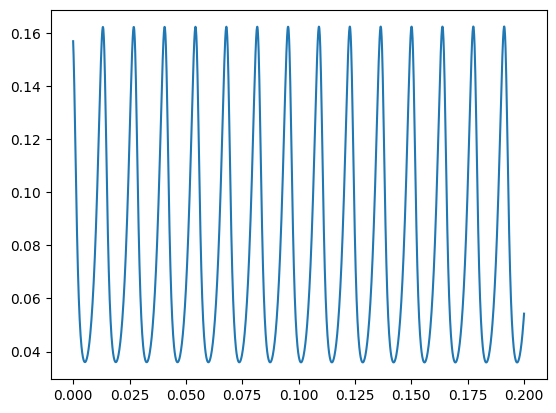

In [45]:
plt.plot(t_chunk, signal_data)

In [46]:
maxima, _ = signal.find_peaks(signal_data)
minima, _ = signal.find_peaks(-signal_data)

# Combine and sort all extrema
extrema = np.sort(np.concatenate((maxima, minima)))

# Calculate periods
periods = np.diff(extrema[::2])  # Every other extremum for full cycles

mean_interval = np.mean(periods)
rel_std_interval = np.std(periods) / mean_interval
print(rel_std_interval)

# Check amplitudes
amplitudes = np.abs(signal_data[extrema[1:]] - signal_data[extrema[:-1]])
print(amplitudes)
print(np.allclose(amplitudes, np.mean(amplitudes), rtol=1e-2))

0.0029997716169911375
[0.1264436  0.12646401 0.12646037 0.1264758  0.12650612 0.1265171
 0.12656134 0.12657572 0.12659276 0.12660591 0.12659827 0.12660792
 0.12661143 0.12661794 0.12665924 0.12666617 0.12668638 0.12669605
 0.12669647 0.12670355 0.12668529 0.12668997 0.12670153 0.126704
 0.12673512 0.12673913 0.12675342 0.12675974]
True


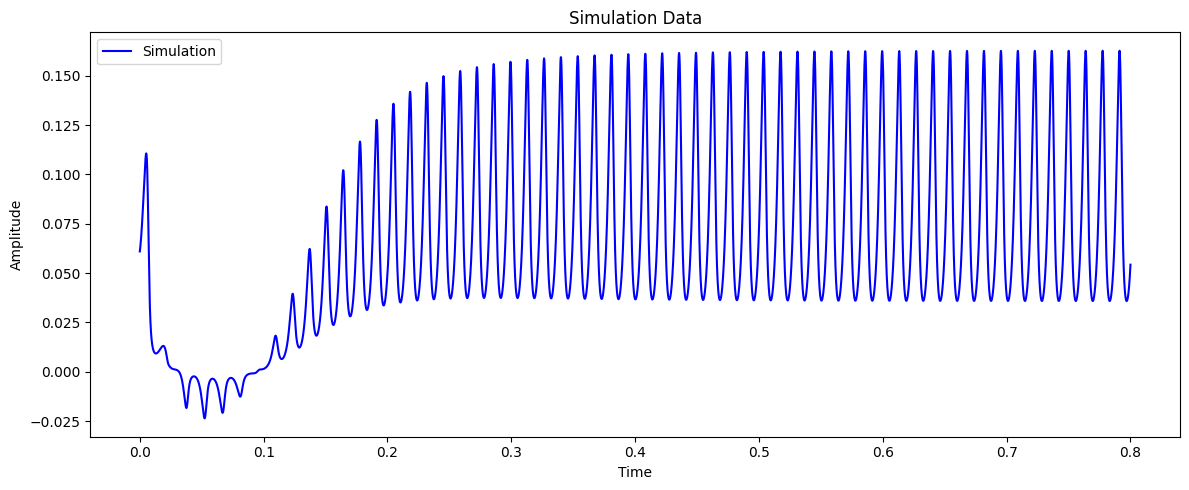

In [47]:
# Assume idx, t, sim, z_func, model.kwargs are already defined
idx = 0

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the simulation data
ax.plot(t, total_traj[:, idx].detach().numpy(), label='Simulation', color='blue')
ax.set_title('Simulation Data')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.legend()
# ax.grid(True)

plt.tight_layout()
plt.show()

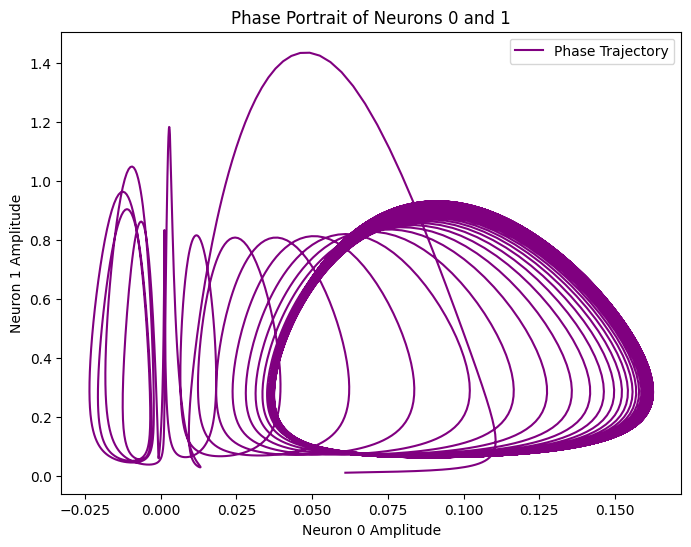

In [48]:
# Extract the simulation data for neurons 0 and 1
sim_neuron0 = total_traj[:, idx].detach().numpy()
sim_neuron1 = total_traj[:, idx + 101].detach().numpy()

# Create the phase portrait plot
plt.figure(figsize=(8, 6))
plt.plot(sim_neuron0, sim_neuron1, label='Phase Trajectory', color='purple')
plt.xlabel('Neuron 0 Amplitude')
plt.ylabel('Neuron 1 Amplitude')
plt.title('Phase Portrait of Neurons 0 and 1')
plt.legend()
# plt.grid(True)
plt.show()